<a href="https://www.kaggle.com/code/klaidenx/fake-news-classification?scriptVersionId=138419643" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#!pip install numpy==1.22.0

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [54]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional,\
                                    SimpleRNN,Conv1D,Embedding, \
                                    Dense,Dropout,GlobalAveragePooling1D
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords

stopwords=stopwords.words("english")

<h1 style="color:#FD8D14;text-align:center;font-weight:bold;text-transform:uppercase">Data Reading</h1>

In [5]:
path="../input/fake-and-real-news-dataset"

In [6]:
def reading_data(data="data"):
    """ 
    __Description__: Function to read data from the path
    _args_: 
        Data : The path to the csv files
    """
    
    true=pd.read_csv(f"{data}/True.csv")
    fake=pd.read_csv(f"{data}/Fake.csv")
    return true,fake

true_data,fake_data=reading_data(path)

In [7]:
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
true_data.info(),\
print(""),\
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


(None, None, None)

In [10]:
tdata_subjects=true_data["subject"].unique()
fdata_subjects=fake_data["subject"].unique()
print(tdata_subjects,fdata_subjects)

['politicsNews' 'worldnews'] ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


In [11]:
def true_subjects_count(news_type,col="subject"):
    news_dict={}
    for news in news_type:
        news_dict[news]=len(true_data[true_data[col]==news])
    return news_dict
def fake_subjects_count(news_type,col="subject"):
    news_dict={}
    for news in news_type:
        news_dict[news]=len(fake_data[fake_data[col]==news])
    return news_dict

true_news_count=true_subjects_count(tdata_subjects)
fake_news_types=fake_subjects_count(fdata_subjects)

In [12]:
{print(f"There is a total in news type of {v} {k} which are true") for k,v in true_news_count.items()}
print()
{print(f"There is a total of news type {v} {k} which are fake") for k,v in fake_news_types.items()}

There is a total in news type of 11272 politicsNews which are true
There is a total in news type of 10145 worldnews which are true

There is a total of news type 9050 News which are fake
There is a total of news type 6841 politics which are fake
There is a total of news type 1570 Government News which are fake
There is a total of news type 4459 left-news which are fake
There is a total of news type 783 US_News which are fake
There is a total of news type 778 Middle-east which are fake


{None}

In [13]:
true_data["News Type"]="Real"
fake_data["News Type"]="Fake"
print(true_data.shape,fake_data.shape)

(21417, 5) (23481, 5)


In [14]:
true_data.columns

Index(['title', 'text', 'subject', 'date', 'News Type'], dtype='object')

In [15]:
merged_data=pd.merge(true_data,fake_data,on=list(true_data.columns),how='outer')
merged_data=merged_data.sample(frac=1).reset_index(drop=True)
merged_data

,title,text,subject,date,News Type
0,Gov. Cuomo Defends Not Endorsing Mayor de Blas...,NY Governor Andrew Cuomo made two shocking ann...,Government News,"Sep 4, 2017",Fake
1,Watch This Brutal New Ad Featuring Trump Mock...,As Trump begins his second try at softening ...,News,"June 8, 2016",Fake
2,Spanish police raid Catalan government to halt...,MADRID/BARCELONA (Reuters) - Spanish police ra...,worldnews,"September 20, 2017",Real
3,Republicans in House launch probe of Russia de...,WASHINGTON (Reuters) - Republican leaders of t...,politicsNews,"October 24, 2017",Real
4,French see far-left's Melenchon as Macron's st...,PARIS (Reuters) - French voters view far lefti...,worldnews,"September 5, 2017",Real
...,...,...,...,...,...
44893,LEFTISTS USE TRUMP To Teach Kids How To Use Vi...,Just when you thought only Muslim terrorists t...,left-news,"Dec 12, 2015",Fake
44894,How Trump is Accelerating the Decline of US Gl...,It should also be said that the current US Adm...,Middle-east,"December 29, 2017",Fake
44895,Armed White Thugs Hunt Down Black Teen Until ...,A 16-year-old is dead after a group of white t...,News,"June 3, 2016",Fake
44896,Trump angers UK with truculent tweet to May af...,LONDON (Reuters) - U.S. President Donald Trump...,politicsNews,"November 30, 2017",Real


<h1 style="color:#FD8D14;text-align:center;font-weight:bold">PREPROCESSING</h1>

In [16]:
titles=[x for x in merged_data["title"]]
text=[x.split("''") for x in merged_data["text"]]
titles[:10]

['Gov. Cuomo Defends Not Endorsing Mayor de Blasio…Speaks Up On ‘Offensive Statues’ Of Christopher Columbus',
 ' Watch This Brutal New Ad Featuring Trump Mocking Disabled Person – Will Air In Swing States',
 'Spanish police raid Catalan government to halt banned referendum',
 'Republicans in House launch probe of Russia deal involving U.S. uranium',
 "French see far-left's Melenchon as Macron's strongest opponent: poll",
 'OBAMA’S RADICAL DHS Chief Vows To “Protect” Muslims From Americans During Speech At DC Mosque',
 'Russia accuses U.S.-led coalition of trying to partition Syria',
 'FEDERAL PROSECUTOR Working On Plea Deal For ISIS Supporter Who Wanted To Bomb LA Subway System And Daughter’s Day Care Center',
 ' WATCH: ‘House’ Actor Hugh Laurie BURNS Trump During His Golden Globes Acceptance Speech',
 'Senator asks ethics office to review Trump hotel payments']

In [17]:
processed_titles=[word for word in titles if word.lower() not in stopwords]
processed_text=[sentence for stop in stopwords for sentence in text if stop not in sentence]

In [18]:
encoder=OneHotEncoder()
merged_data["News Type"]=encoder.fit_transform(merged_data[["News Type"]]).toarray()
merged_data.head()

,title,text,subject,date,News Type
0,Gov. Cuomo Defends Not Endorsing Mayor de Blas...,NY Governor Andrew Cuomo made two shocking ann...,Government News,"Sep 4, 2017",1.0
1,Watch This Brutal New Ad Featuring Trump Mock...,As Trump begins his second try at softening ...,News,"June 8, 2016",1.0
2,Spanish police raid Catalan government to halt...,MADRID/BARCELONA (Reuters) - Spanish police ra...,worldnews,"September 20, 2017",0.0
3,Republicans in House launch probe of Russia de...,WASHINGTON (Reuters) - Republican leaders of t...,politicsNews,"October 24, 2017",0.0
4,French see far-left's Melenchon as Macron's st...,PARIS (Reuters) - French voters view far lefti...,worldnews,"September 5, 2017",0.0


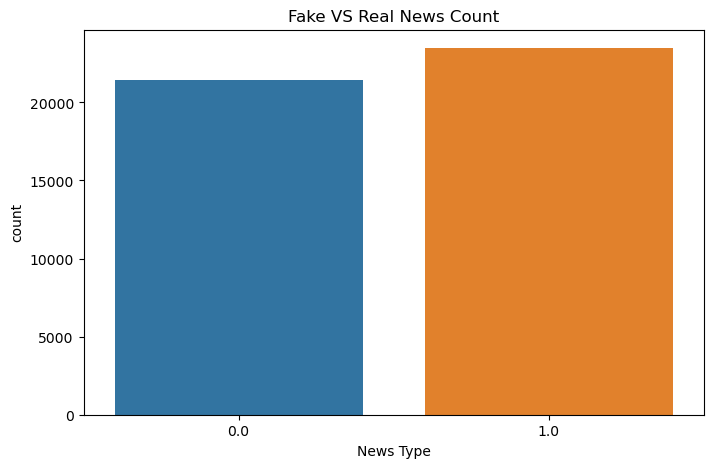

In [19]:
plt.figure(figsize=(8,5))
sns.countplot(data=merged_data,x="News Type")
plt.title("Fake VS Real News Count")
plt.show()

In [20]:
titles_maxlen=max([len(x) for x in processed_titles])
text_maxlen=max([len(text) for x in processed_text for text in x])
print(f"The longest title in titles is {titles_maxlen} character long.")
print(f"The longest text in texts is {text_maxlen} character long.")

The longest title in titles is 286 character long.
The longest text in texts is 51794 character long.


In [21]:
tokenizer_titles=Tokenizer(oov_token="[UKN]")
tokenizer_titles.fit_on_texts(processed_titles)
titles_totalwords=len(tokenizer_titles.word_index)+1
titles_totalwords

31804

In [22]:
tokenizer_text=Tokenizer(oov_token="[UKN]")
tokenizer_text.fit_on_texts(processed_text)
text_totalwords=len(tokenizer_text.word_index)+1
text_totalwords

38651

In [23]:
sequence_titles=tokenizer_titles.texts_to_sequences(processed_titles)
padd_titles=pad_sequences(sequence_titles,padding="post",maxlen=titles_maxlen)
type(padd_titles)

numpy.ndarray

In [24]:

X_train_titles,X_test_titles,y_train_titles,y_test_titles=train_test_split(padd_titles,\
                                                                           merged_data["News Type"].values,\
                                                                           test_size=.3,shuffle=True,\
                                                                           random_state=1234)

X_train_titles.shape,y_train_titles.shape

((31428, 286), (31428,))

<h1 style="color:#FD8D14;text-align:center;text-transform:uppercase;font-weight:bold">Building Model With Convolution</h1>

<h2 style="color:#1D5B79">True And Fake Titles With Convolution </h2>

In [25]:
model=Sequential()
model.add(Embedding(titles_totalwords,200,input_length=titles_maxlen))
model.add(Conv1D(128,5,activation="relu"))
model.add(Dropout(rate=.2))
model.add(GlobalAveragePooling1D())
model.add(Dense(32,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [26]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 286, 200)          6360800   
                                                                 
 conv1d (Conv1D)             (None, 282, 128)          128128    
                                                                 
 dropout (Dropout)           (None, 282, 128)          0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                        

In [27]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
with tf.device("GPU:0"):
    history=model.fit(X_train_titles,y_train_titles,validation_data=(X_test_titles,y_test_titles),epochs=10)

Epoch 1/10
983/983 [==============================] - 33s 34ms/step - loss: 0.1929 - accuracy: 0.9161 - val_loss: 0.0952 - val_accuracy: 0.9645
Epoch 2/10
983/983 [==============================] - 11s 11ms/step - loss: 0.0493 - accuracy: 0.9840 - val_loss: 0.0890 - val_accuracy: 0.9689
Epoch 3/10
983/983 [==============================] - 10s 10ms/step - loss: 0.0217 - accuracy: 0.9930 - val_loss: 0.0981 - val_accuracy: 0.9680
Epoch 4/10
983/983 [==============================] - 9s 9ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.1212 - val_accuracy: 0.9656
Epoch 5/10
983/983 [==============================] - 8s 8ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.1669 - val_accuracy: 0.9591
Epoch 6/10
983/983 [==============================] - 9s 9ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1819 - val_accuracy: 0.9645
Epoch 7/10
983/983 [==============================] - 8s 8ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.2155 - val_accuracy: 0.9612


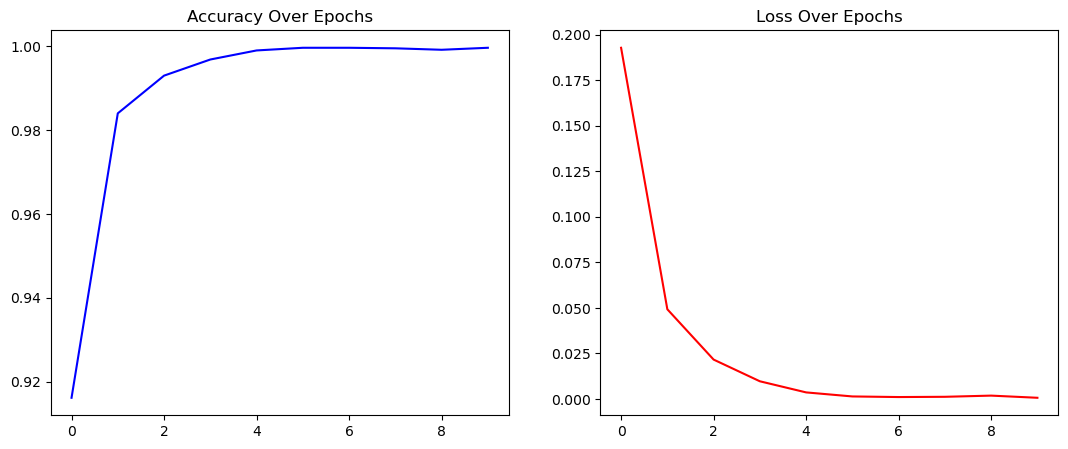

In [46]:
acc=history.history["accuracy"]
loss=history.history["loss"]
epochs=range(len(acc))

fig,axs=plt.subplots(1,2,figsize=(13,5))
axs[0].plot(epochs,acc,color="blue")
axs[0].set_title("Accuracy Over Epochs")
axs[1].plot(epochs,loss,color="red")
axs[1].set_title("Loss Over Epochs")
plt.show()